In [18]:
## libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
import glob as gb
import os
from tensorflow.keras.layers import Dense , AveragePooling2D , Flatten , Dropout , BatchNormalization , Input
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [3]:
## check images and encode
check = {"without_mask":0 , "with_mask":1}
def getcheck(n):
    for x , y in check.items():
        if n == y:
            return x

In [4]:
with_mask = r"D:\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset\with_mask"
without_mask = r"D:\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset\without_mask"
data_folder = r"D:\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset"

In [5]:
## display num of image in data folder
for folder in os.listdir(data_folder):
    folder_path = os.path.join(data_folder , folder)
    files = gb.glob(os.path.join(folder_path , "*.jpg"))
    print(f"for data_folder , there are {len(files)} images in folder {folder}")

for data_folder , there are 1918 images in folder without_mask
for data_folder , there are 1787 images in folder with_mask


In [6]:
## show size image in data_folder
size = []
for folder in os.listdir(data_folder):
    folder_path = os.path.join(data_folder , folder)
    files = gb.glob(os.path.join(folder_path , "*.jpg"))
    for file in files:
        image = cv2.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(428, 320, 3)      213
(100, 100, 3)      157
(433, 320, 3)       46
(1000, 1000, 3)     31
(800, 800, 3)       24
                  ... 
(263, 244, 3)        1
(326, 307, 3)        1
(439, 589, 3)        1
(439, 473, 3)        1
(302, 211, 3)        1
Name: count, Length: 2360, dtype: int64

In [7]:
## initial size
s = 224

In [8]:
## make images in same size 

X = []
Y = []
for folder in os.listdir(data_folder):
    folder_path = os.path.join(data_folder , folder)
    files = gb.glob(os.path.join(folder_path , "*.jpg"))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))
        X.append(list(image_array))
        Y.append(check[folder])
        
X = np.array(X)/255.0
Y = np.array(Y)

In [9]:
## split X and Y
x_train , x_test , y_train , y_test = train_test_split(X , Y , random_state = 42 , test_size = 0.2)
x_train , x_val , y_train , y_val = train_test_split(x_train , y_train , random_state = 42 , test_size = 0.2)

In [10]:
## data augmentaition
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True
)

datagen.fit(x_train)

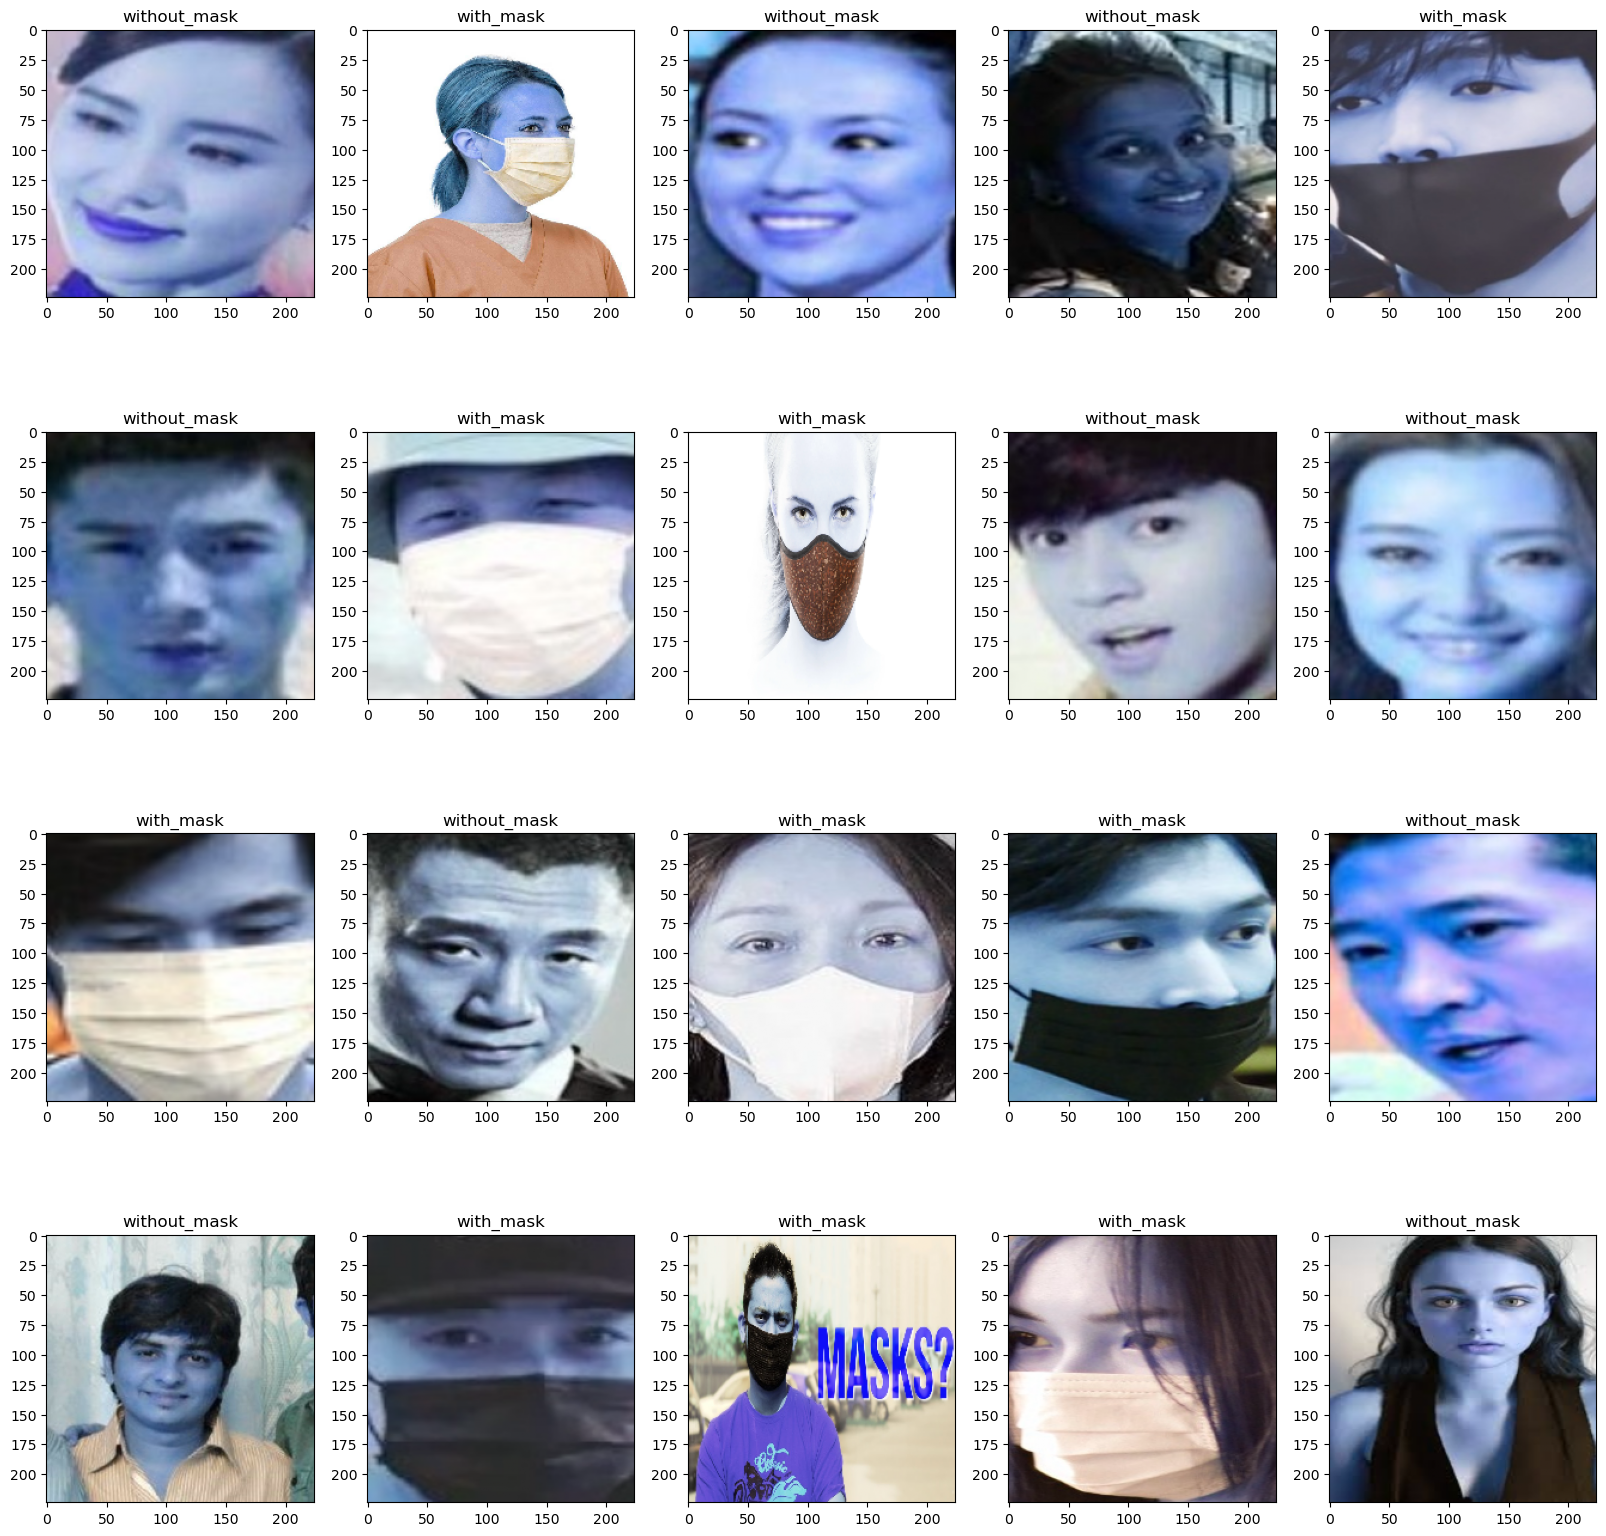

In [11]:
## plot image in train
plt.figure(figsize = (20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_train) , 20))):
    plt.subplot(4,5,n+1)
    plt.imshow(x_train[i])
    plt.title(getcheck(y_train[i]))


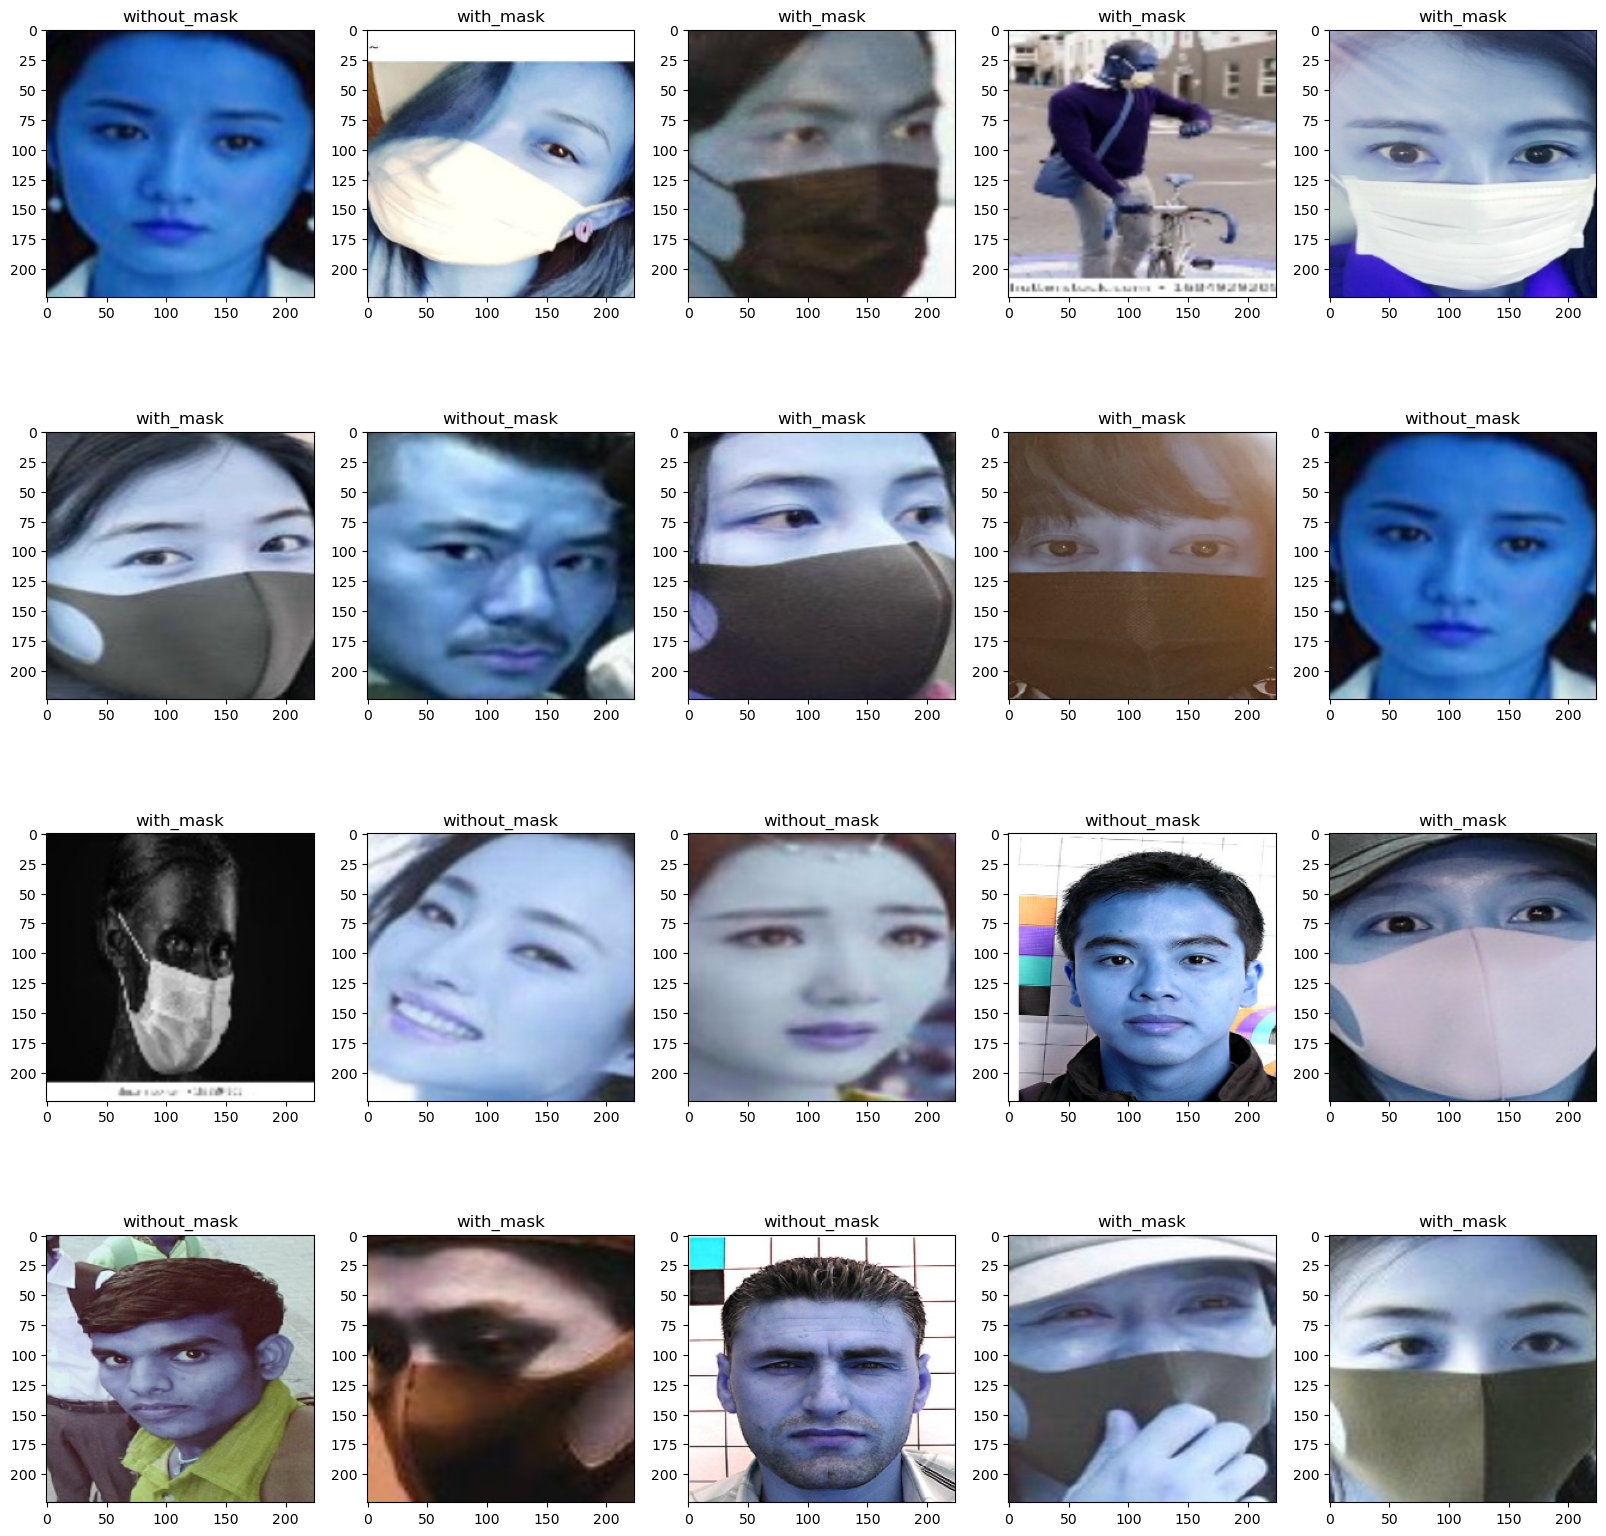

In [12]:
## show image in test
plt.figure(figsize = (20,20))
for n , i in enumerate(list(np.random.randint(0 , len(x_test) , 20))):
    plt.subplot(4,5,n+1)
    plt.imshow(x_test[i])
    plt.title(getcheck(y_test[i]))

In [13]:
## display num of image after splitting and display size 
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

print("x_train shape is " , x_train.shape)
print("x_test shape is " , x_test.shape)
print("y_train shape is " , y_train.shape)
print("y_test shape is " , y_test.shape)
print("x_val shape is " , x_val.shape)
print("y_val shape is " , y_val.shape)

x_train shape is  (2371, 224, 224, 3)
x_test shape is  (741, 224, 224, 3)
y_train shape is  (2371,)
y_test shape is  (741,)
x_val shape is  (593, 224, 224, 3)
y_val shape is  (593,)


In [19]:
## building model

input_shape = (224 , 224 , 3)
base_model = MobileNetV2(weights = "imagenet" , include_top = False , input_shape = input_shape)

for layer in base_model.layers:
    layer.trainable = False

## add layers

inputs = Input(shape = input_shape)
X = base_model(inputs , training = False)
X = AveragePooling2D(pool_size = (7,7))(X)
X = Flatten()(X)
X = Dense(1024 , activation = "relu")(X)
X = Dense(1 , activation = "sigmoid")(X)

model = Model(inputs , X)


In [20]:
model.compile(optimizer = Adam(learning_rate = 0.001) , loss = "binary_crossentropy" , metrics = ["accuracy"])

In [21]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 1, 1, 1280)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping
lr = ReduceLROnPlateau(monitor = "val_loss" , patience = 2 , factor = 0.5 , min_lr = 0.00001)
es = EarlyStopping(monitor = "val_loss" , patience = 2 , restore_best_weights = True)

In [23]:
history = model.fit(datagen.flow(x_train ,y_train , batch_size = 64) , validation_data = (x_val , y_val) , epochs = 20 , callbacks = [lr] , verbose = 1)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7339 - loss: 0.9261 - val_accuracy: 0.9680 - val_loss: 0.0903 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9466 - loss: 0.1382 - val_accuracy: 0.9764 - val_loss: 0.0587 - learning_rate: 0.0010
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9588 - loss: 0.0922 - val_accuracy: 0.9865 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9688 - loss: 0.0805 - val_accuracy: 0.9781 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9710 - loss: 0.0704 - val_accuracy: 0.9916 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9753 - loss: 0.0661 - val_accuracy: 0.9899 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9840 - loss: 0.0498 - val_accuracy: 

In [24]:
test_loss , test_accuracy = model.evaluate(x_test , y_test)
print("test accuracy is" , test_accuracy)
print("test_loss is" , test_loss)

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 505ms/step - accuracy: 0.9794 - loss: 0.0445
test accuracy is 0.9824561476707458
test_loss is 0.04111938551068306


In [25]:
## classification_report
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test , y_pred , target_names = ["without_mask" , "with_mask"]))

24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 548ms/step
              precision    recall  f1-score   support

without_mask       0.98      0.99      0.98       403
   with_mask       0.99      0.98      0.98       338

    accuracy                           0.98       741
   macro avg       0.98      0.98      0.98       741
weighted avg       0.98      0.98      0.98       741



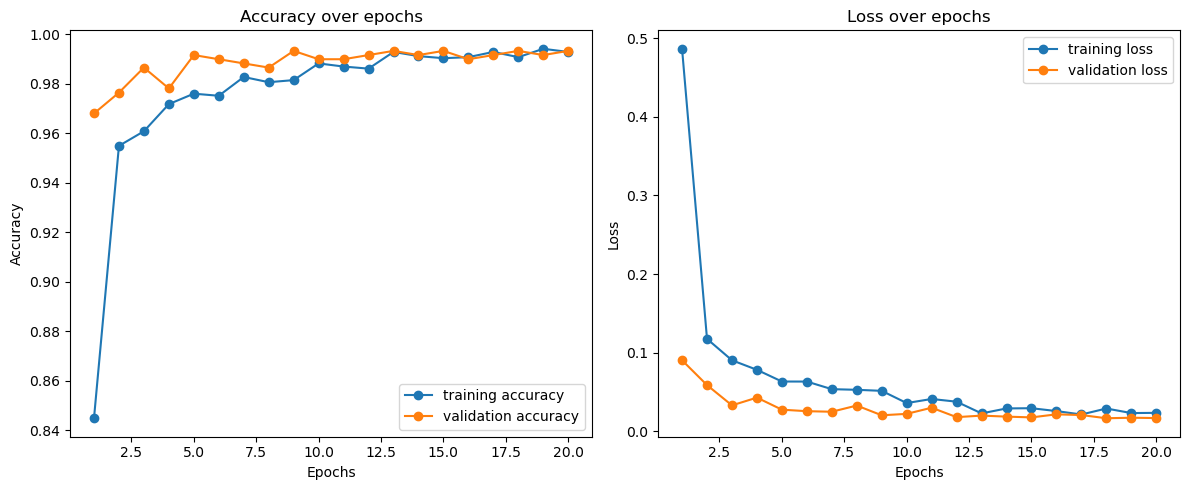

In [28]:
acc = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
loss = history.history["loss"]

epochs = range(1 , len(acc) + 1)

plt.figure(figsize = (12 , 5))

## display curve accuracy
plt.subplot(1 , 2, 1)
plt.plot(epochs , acc , label = "training accuracy" , marker = "o")
plt.plot(epochs , val_accuracy , label = "validation accuracy" , marker = "o")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## display curve loss

plt.subplot(1 , 2, 2)
plt.plot(epochs , loss , label = "training loss" , marker = "o")
plt.plot(epochs , val_loss , label = "validation loss" , marker = "o")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## display figure

plt.tight_layout()
plt.show()

In [29]:
## predict model
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os


def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array


def predict_mask(img_path):
    prepared_image = prepare_image(img_path)
    prediction = model.predict(prepared_image)
    
    if prediction[0][0] > 0.5:
        return "with_mask"
    else:
        return "without_mask"


img_path = r'C:\Users\Administrator\Downloads\11.jpeg'  
result = predict_mask(img_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
with_mask


In [33]:
## save model

model.save("my_model.keras")

# By :Jana Ashraf